<a href="https://colab.research.google.com/github/phi1z/1yanagiLab/blob/main/SAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 昇温実験から比吸収率(SAR)を計算するWebUIです

## 利用方法

1.   <font color= “blue”>**前提ファイルの読み込み**</font>を実行する
2.   ディレクトリー名(`output_dir`)を入力して実行。左のフォルダーにdataなどが作成されます(**左のフォルダーアイコン**をクリックすると、エクスプローラーが開きます。フォルダーが見当たらないときは、上の<font color= “red”>**更新ボタン**</font>を押して下さい)
3.   data/[ディレクトリー名]/に**測定データ**(txtファイル)をアップロード。<font color= “blue”>**ファイルを確認**</font>を実行して**ファイルを選択**します

4.   表とグラフを確認して、データが正常に読み込めているか確認
5.   初期値(`a,b,k`)を設定してフィッティングを開始。正しくフィッティングできているか確認
6.   試料比熱`C`と誤差`C_sigma`を入力して、<font color= “blue”>**比吸収率(SAR)の計算**</font>でSARが計算されます。また、自動で`out_put`に保存されます

## 結果の読み方
* $R^2$ …… 決定係数。1に近づくほどフィッティングの結果が良い
* $\chi^2$ …… カイ二乗値。フィッティング結果が正しい時の測定誤差の二乗総和
* $P$ …… P値。フィッティングが偶然**ではない**確率
* $COV(\sigma_{ij})$ …… 共分散行列。パラメーター同士の分散と共分散をまとめたもの
* $SAR$ …… 比吸収率。単位は W/g です。

## その他機能
フィッティングしたグラフを編集して保存できます。ファイルは`graph/`に保存されます

In [ ]:
#@title ##前提ファイルの読み込み (**とりあえず押して！**)

!pip install ipywidgets==7.7.1

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
from scipy.optimize import curve_fit

def count_decimal_places(text):
    if '.' in text:
        return len(text.split('.')[-1])
    else:
        return 0

from IPython.display import clear_output
clear_output()
print("前提ファイルの読み込みが完了しました")

前提ファイルの読み込みが完了しました


In [ ]:
#@title ディレクトリー名の決定 { display-mode: "form"}
#@markdown ##実行ボタンを押してディレクトリー名を決定


#@markdown ###ディレクトリー名を入力
dir_name = "small" # @param {"type":"string"}

os.makedirs("data", exist_ok=True)
dir_name_ud = os.path.join("data", dir_name)
os.makedirs(dir_name_ud, exist_ok=True)

print(f"ディレクトリ名: {dir_name}")


##ファイルをアップロード

###`data/[dir_name]/`に測定データ(.txt)を<font color= “orange”>**アップロード**</font>して下さい



In [ ]:
#@title ファイルを確認 { display-mode: "form"}
#@markdown ##1. 実行ボタンを押してファイルを確認
#@markdown ##2. 解析するファイルを選択 (実行ボタンは押さない)

files = os.listdir(dir_name_ud)
files = np.sort(files)

print(f"ファイル数: {len(files)}")

# ドロップダウンリストを作成
this_file = widgets.Dropdown(
    options=files,
    value=files[0],
    description='ファイルを選択:',
    disabled=False,
    layout={'width': '50%', 'height': '40px'},
    style={'description_width': 'initial'},
)

# 表示
display(this_file)

,Time,Temperature
0,0.1,37.00
1,0.2,37.05
2,0.3,37.05
3,0.4,37.05
4,0.5,37.15


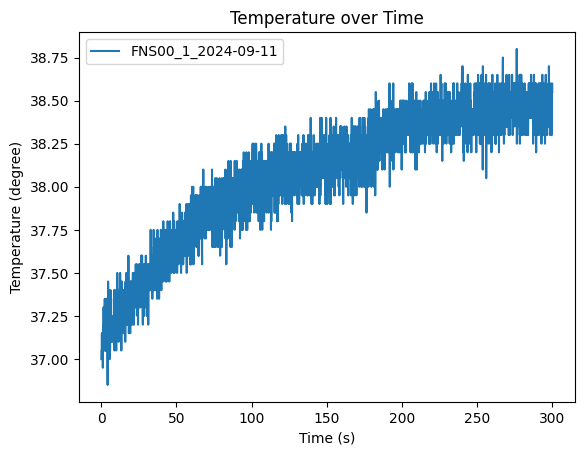

In [ ]:
#@title ##ファイルの読み込み
#@markdown ###正常に読み込まれているか**表**と**グラフ**を確認してください

def read_data(filename):
  with open(filename, 'r') as f:
      lines = f.readlines()

  with open('temp.txt', 'w') as f:
      f.writelines(lines[19:])

  df = pd.read_csv('temp.txt', delimiter='\t')

  df = df.drop(columns=df.columns[-1])
  df.columns = ["Time", "Temperature"]

  # Convert the 'Time' column to datetime objects, handling potential errors
  time_obj = pd.to_datetime(df['Time'], format="%H:%M:%S.%f", errors='coerce')
  # Calculate total seconds since 1900-01-01 for each time entry
  df['Time'] = (time_obj - datetime(1900, 1, 1)).dt.total_seconds()

  return df

def offset_row(data, row, initial=0):
  initial_value = data[row].iloc[0]
  data[row] = data[row] - initial_value + initial
  return data

file_path = os.path.join(dir_name_ud, this_file.value)
file_name = os.path.basename(file_path)
file_name = os.path.splitext(file_name)[0]

df = read_data(file_path)
df = offset_row(df, "Temperature", 37)

display(df.head())

df.plot(x='Time', y='Temperature', label=file_name)

plt.title('Temperature over Time')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (degree)')

plt.legend()

plt.show()



===Result===


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[[ 8.83852825e-05  4.93290425e-05 -1.41744567e-06]
 [ 4.93290425e-05  7.17348807e-05 -5.04952483e-07]
 [-1.41744567e-06 -5.04952483e-07  2.62491556e-08]]

===Fit Parameters===


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


===Graph===


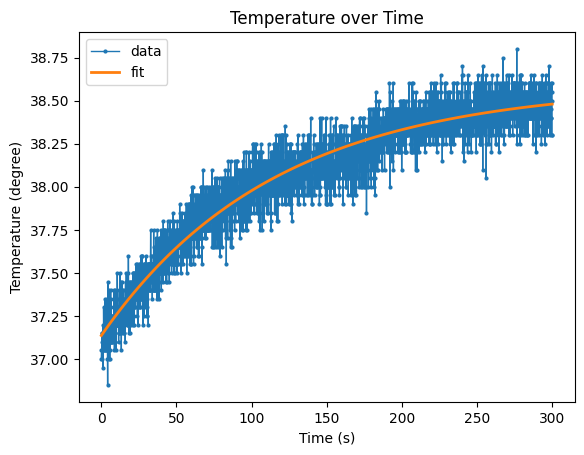

In [ ]:
# @title ##関数でフィッティング

#@markdown フィッティングする関数は、
#@markdown $$T(t) = a - b \exp \left( -k\times t \right)$$
#@markdown $T\cdots$温度 [℃]、$t\cdots$時間 [s]、
#@markdown $a\cdots$換算初期温度 [℃]、$b\cdots$上昇温度 [K]、$k\cdots$温度上昇率 [K/s]

#@markdown ##1. 初期値を設定

from IPython.display import Math
from scipy.stats import chisquare

a = 36 # @param {"type":"number"}
b = 0.5 # @param {"type":"number"}
k = 0.1 # @param {"type":"number"}

#@markdown ※フィッティングが上手くいかない場合は変更してください


def exponential_func(x, a, b, k):
       return a - b * np.exp(-k * x)

def square_error_d2f(x, y, func, param):
    y2 = func(x, *param)
    sse = np.sum((y-y2)**2)
    sst = np.sum((y-np.mean(y))**2)
    return 1 - sse/sst

def chi_square_d2f(x, y, func, param):
    y2 = func(x, *param)
    chi2, p = chisquare(y, f_exp=y2, ddof=len(param)-1)
    return chi2, p

initial_guess = [a, b, k]
popt, pcov = curve_fit(exponential_func, df['Time'], df['Temperature'], p0=initial_guess)
disp_popt = [""]*3
decimals = [1, 2, 4]
for i , p in enumerate(popt):
  disp_popt[i] = f"{p:.{decimals[i]}f}"
sigmas = np.sqrt(np.diag(pcov))
disp_sigmas = [""]*3
for i , p in enumerate(sigmas):
  disp_sigmas[i] = f"{p:.{count_decimal_places(disp_popt[i])}f}"

ROC = square_error_d2f(df['Time'], df['Temperature'], exponential_func, popt)
ROC_disp = f"{ROC:.4g}"
chi_square, p_value = chi_square_d2f(df['Time'], df['Temperature'], exponential_func, popt)
chi_square = f"{chi_square:.4g}"
p_value = f"{p_value:.4g}"

delta_T = df['Temperature'].iloc[-1] - df['Temperature'].iloc[0]
delta_TB = abs(delta_T - popt[1])
delta_TB = f"{delta_TB:.4g}"

print("===Result===")

display(Math(r'$R^2 = {roc}$'.format(roc=ROC_disp)))
display(Math(r'$\chi^2 = {chi_sq}$'.format(chi_sq=chi_square)))
display(Math(r'$P = {p}$'.format(p=p_value)))
display(Math(r'$COV(\sigma_{ij}) = $'))
print(pcov)

print("\n===Fit Parameters===")
display(Math(r'$a = {pa} \pm {sa} {{}}^\circ\mathrm{{C}}$'.format(pa=disp_popt[0], sa=disp_sigmas[0])))
display(Math(r'$b = {pb} \pm {sb} {{}}^\circ\mathrm{{C}}$'.format(pb=disp_popt[1], sb=disp_sigmas[1])))
display(Math(r'$k = {pk} \pm {sk} \:\mathrm{{K/s}}$'.format(pk=disp_popt[2], sk=disp_sigmas[2])))
display(Math(r'$\left| \Delta T - b \right| = {db} \:\mathrm{{K}}$'.format(db=delta_TB)))

print("\n===Graph===")

fit_x = np.linspace(df['Time'].min(), df['Time'].max(), 100)
fit_y = exponential_func(fit_x, *popt)
fit_y_ts = exponential_func(df['Time'], *popt)

plt.plot(df['Time'], df['Temperature'], 'o-', label='data',
         linewidth=1, markersize=2
         )
plt.plot(fit_x, fit_y, '-', label='fit', linewidth=2)

plt.title('Temperature over Time')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (degree)')

plt.legend()

plt.show()

In [ ]:
#@title 比吸収率(SAR)の計算
#@markdown ### 比吸収率(SAR)は以下の式で与えられます
#@markdown $$SAR = C \times \Delta T \times k$$
#@markdown $C\cdots$試料の比熱 [J/(K$\cdot$g)]]、$\Delta T\cdots$上昇温度[K]、$k\cdots$温度上昇率 [K/s]

#@markdown ※温度上昇率は実際のデータ、もしくは以下の式から求まります
#@markdown $$ \Delta T = T(t\to\infty) - T(0) = a - (a - b) = b $$

#@markdown ##1. 試料の比熱を入力
#@markdown ※単位は **J/g** で入力してください

#@markdown ※誤差は`C_sigma`に書いてください

C = 4.178 # @param {"type":"number"}
C_sigma = 0 # @param {"type":"number"}

#@markdown ##2. 温度上昇の定義
#@markdown 実際の温度上昇$\Delta T$で計算する場合はチェック

delta_T_check = False # @param {type:"boolean"}

del_T = popt[1]
del_T_sigma = sigmas[1]
if delta_T_check:
  del_T = delta_T
  del_T_sigma = 2 * np.sqrt(np.sum((df['Temperature'] - fit_y_ts)**2)) / len(df['Temperature'])

SAR = C * del_T * popt[2]
SAR = f"{SAR:.3g}"

SAR_sigma = np.sqrt( del_T_sigma**2 * C * popt[2] + sigmas[2]**2 * C * popt[1] + C_sigma ** 2 * popt[1] * popt[2] )
SAR_sigma = f"{SAR_sigma:.{count_decimal_places(SAR)}f}"

print("===Result===")
display(Math(r'$SAR = {sar} \pm {sar_sd} \:\mathrm{{W/g}}$'.format(sar=SAR, sar_sd=SAR_sigma)))

print("\n===Save===")
os.makedirs("out_put", exist_ok=True)
out_put = os.path.join("out_put", f"{file_name}_result.txt")
out_text = f"===SAR===\n"
out_text += f"SAR = {SAR} ± {SAR_sigma} W/g\n"
out_text += f"n===Fit Parameters===\n"
out_text += f"a = {disp_popt[0]} ± {disp_sigmas[0]} ℃\n"
out_text += f"b = {disp_popt[1]} ± {disp_sigmas[1]} ℃\n"
out_text += f"k = {disp_popt[2]} ± {disp_sigmas[2]} K/s\n"
out_text += f"\n===Fitting Result===\n"
out_text += f"R^2 = {ROC_disp}\n"
out_text += f"χ^2 = {chi_square}\n"
out_text += f"P = {p_value}\n"

with open(out_put, mode='w') as f:
  f.write(out_text)

print(f"結果を {out_put} に保存しました")
print("\n===↓出力結果↓===\n")
print(out_text)

===Result===


<IPython.core.display.Math object>


===Save===
結果を out_put/FNS00_1_2024-09-11_result.txt に保存しました

===↓出力結果↓===

===SAR===
SAR = 0.0526 ± 0.0017 W/g
n===Fit Parameters===
a = 38.6 ± 0.0 ℃
b = 1.45 ± 0.01 ℃
k = 0.0087 ± 0.0002 K/s

===Fitting Result===
R^2 = 0.919
χ^2 = 0.9431
P = 1



In [ ]:
#@title グラフの作成 { display-mode: "form"}
#@markdown ###タイトル
title = "Temperature over Time" # @param {"type":"string"}
#@markdown ###グラフ全体のスタイル
graph_style = "ggplot" # @param ["seaborn", "fivethirtyeight", "ggplot","bmh", "classic", "dark_background", "grayscale", "fast", "seaborn-bright", "seaborn-colorblind", "seaborn-dark", "seaborn-poster", "seaborn-darkgrid"]
#@markdown ###タイトルのフォントサイズ
title_font_size = 24 # @param {type:"slider", min:10, max:60, step:1}
#@markdown ###$x$軸名
xlabel = "Time (s)" # @param {"type":"string"}
#@markdown ###$y$軸名
ylabel = "Temperature (degree)" # @param {"type":"string"}
#@markdown ###データのラベル
dlabel = "measured data" # @param {"type":"string"}
#@markdown ###軸名のフォントサイズ
font_size = 20 # @param {type:"slider", min:10, max:40, step:1}
#@markdown ###フィッティングのラベル
fit_label = "fitting" # @param {"type":"string"}
#@markdown ###データの色
color = "#1f77b4" #@param ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] {allow-input: true}
#@markdown ###データの線スタイル
linestyle = "o-" #@param ["o", "o-", "-", "--", "-.", ":"] {allow-input: true}
#@markdown ###データの線幅
linewidth = 1 #@param {type:"slider", min:0, max:10, step:0.1}
#@markdown ###データのマーカーサイズ
markersize = 2 #@param {type:"slider", min:0, max:10, step:0.1}
#@markdown ###フィッティングの色
fit_color = "#ff7f0e" #@param ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] {allow-input: true}
#@markdown ###フィッティングの線スタイル
fit_linestyle = "-" #@param ["-", "--", "-.", ":"] {allow-input: true}
#@markdown ###フィッティングの線幅
fit_linewidth = 2 #@param {type:"slider", min:0, max:10, step:0.1}
#@markdown ###凡例のサイズ
legend_font_size = 16 #@param {type:"slider", min:10, max:40, step:1}

plt.plot(df['Time'], df['Temperature'], linestyle, label=dlabel,
         linewidth=linewidth, markersize=markersize, color=color)
plt.plot(fit_x, fit_y, fit_linestyle, label=fit_label,
         linewidth=fit_linewidth, color=fit_color)

plt.style.use(graph_style)

plt.title(title, fontsize=title_font_size)
plt.xlabel(xlabel, fontsize=font_size)
plt.ylabel(ylabel, fontsize=font_size)

plt.legend(fontsize=legend_font_size)

os.makedirs("graph", exist_ok=True)
plt.savefig(f"graph/{file_name}.png")
print(f"グラフを graph/{file_name}.png に保存しました")

plt.show()



===Result===


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

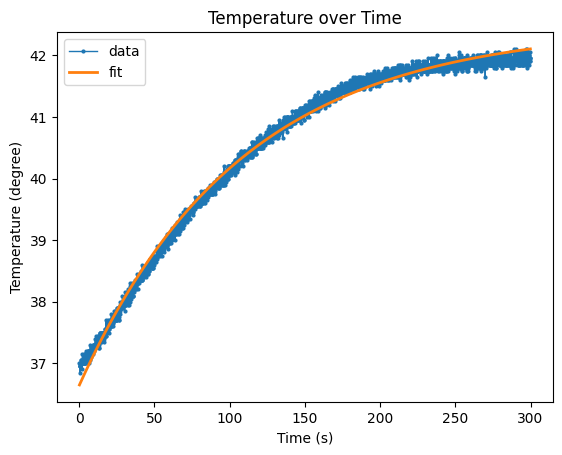

===Result===


<IPython.core.display.Math object>


===Save===
結果を out_put/1K_60_3_result.txt に保存しました


In [ ]:
# @title at once

file_path = os.path.join(dir_name_ud, this_file.value)
file_name = os.path.basename(file_path)
file_name = os.path.splitext(file_name)[0]

df = read_data(file_path)
df = offset_row(df, "Temperature", 37)

a = 36 # @param {"type":"number"}
b = 0.5 # @param {"type":"number"}
k = 0.1 # @param {"type":"number"}

initial_guess = [a, b, k]
popt, pcov = curve_fit(exponential_func, df['Time'], df['Temperature'], p0=initial_guess)
disp_popt = [""]*3
decimals = [1, 2, 4]
for i , p in enumerate(popt):
  disp_popt[i] = f"{p:.{decimals[i]}f}"
sigmas = np.sqrt(np.diag(pcov))
disp_sigmas = [""]*3
for i , p in enumerate(sigmas):
  disp_sigmas[i] = f"{p:.{count_decimal_places(disp_popt[i])}f}"

ROC = square_error_d2f(df['Time'], df['Temperature'], exponential_func, popt)
ROC_disp = f"{ROC:.4g}"
chi_square, p_value = chi_square_d2f(df['Time'], df['Temperature'], exponential_func, popt)
chi_square = f"{chi_square:.4g}"
p_value = f"{p_value:.4g}"

delta_T = df['Temperature'].iloc[-1] - df['Temperature'].iloc[0]
delta_TB = abs(delta_T - popt[1])
delta_TB = f"{delta_TB:.4g}"

print("===Result===")

display(Math(r'$R^2 = {roc}$'.format(roc=ROC_disp)))
display(Math(r'$\chi^2 = {chi_sq}$'.format(chi_sq=chi_square)))
display(Math(r'$P = {p}$'.format(p=p_value)))

fit_x = np.linspace(df['Time'].min(), df['Time'].max(), 100)
fit_y = exponential_func(fit_x, *popt)
fit_y_ts = exponential_func(df['Time'], *popt)

plt.plot(df['Time'], df['Temperature'], 'o-', label='data',
         linewidth=1, markersize=2
         )
plt.plot(fit_x, fit_y, '-', label='fit', linewidth=2)

plt.title('Temperature over Time')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (degree)')

plt.legend()

plt.show()

C = 4.178 # @param {"type":"number"}
C_sigma = 0 # @param {"type":"number"}

delta_T_check = False # @param {type:"boolean"}

del_T = popt[1]
del_T_sigma = sigmas[1]
if delta_T_check:
  del_T = delta_T
  del_T_sigma = 2 * np.sqrt(np.sum((df['Temperature'] - fit_y_ts)**2)) / len(df['Temperature'])

SAR = C * del_T * popt[2]
SAR = f"{SAR:.3g}"

SAR_sigma = np.sqrt( del_T_sigma**2 * C * popt[2] + sigmas[2]**2 * C * popt[1] + C_sigma ** 2 * popt[1] * popt[2] )
SAR_sigma = f"{SAR_sigma:.{count_decimal_places(SAR)}f}"

print("===Result===")
display(Math(r'$SAR = {sar} \pm {sar_sd} \:\mathrm{{W/g}}$'.format(sar=SAR, sar_sd=SAR_sigma)))

print("\n===Save===")
os.makedirs("out_put", exist_ok=True)
out_put = os.path.join("out_put", f"{file_name}_result.txt")
out_text = f"===SAR===\n"
out_text += f"SAR = {SAR} ± {SAR_sigma} W/g\n"
out_text += f"n===Fit Parameters===\n"
out_text += f"a = {disp_popt[0]} ± {disp_sigmas[0]} ℃\n"
out_text += f"b = {disp_popt[1]} ± {disp_sigmas[1]} ℃\n"
out_text += f"k = {disp_popt[2]} ± {disp_sigmas[2]} K/s\n"
out_text += f"\n===Fitting Result===\n"
out_text += f"R^2 = {ROC_disp}\n"
out_text += f"χ^2 = {chi_square}\n"
out_text += f"P = {p_value}\n"

with open(out_put, mode='w') as f:
  f.write(out_text)

print(f"結果を {out_put} に保存しました")
